In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

import model_based_agent as mba 
import worm_env as we 
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab

# Data collection

In [2]:
folder = './Data/Rand'+datetime.now().strftime('%d-%m-%H-%M')+'/'
if os.path.isdir(folder):
    raise ValueError('Folder already exists.')
os.mkdir(folder)

worm_num = 0
worm = we.ProcessedWorm(0,ep_len=300)

In [30]:
fname = f'{folder}Rand{worm_num}.pkl'
mba.get_init_traj(fname, worm, 6)
worm_num += 1

Done resetting	
Done resetting	
Done resetting	
Done resetting	
Done resetting	
Done resetting	


# Does this set do as well as the last one?

In [134]:
def load_folder(fold,name,n=15):
    # Loads trajectories into a dict with lists of arrays. 
    trajs = []
    for i in range(n):
        with open(f'{fold}{name}{i}.pkl','rb') as f:
            trajs.append(pickle.load(f))
    
    t_dict = {}
    for k in trajs[0].keys():
        t_dict[k] = [np.array(trajs[i][k]).flatten() for i in range(n)]
        if k=='loc' or k=='obs':
            t_dict[k] = [t_dict[k][i].reshape(-1,2) for i in range(n)]
    return t_dict

def change_reward_ahead(df,reward_ahead,jump_limit=100):
    # Takes a dataframe where reward_ahead setting was 1.
    # Rewrites reward column using new reward_ahead
    # Returns dataframe at the end.
    start_inds = [0]
    for i in range(len(df)-1):
        if pt_dist(df['loc'][i],df['loc'][i+1]) > 10:
            start_inds.append(i+1)

    new_df = pd.DataFrame(columns=df.columns)
    for i in range(len(start_inds)-1):
        new_sec = df.iloc[start_inds[i]:start_inds[i+1]-reward_ahead].copy()
        new_r = [np.sum(dh.df['reward'][start_inds[i]+j:start_inds[i]+j+reward_ahead]) 
                     for j in range(len(new_sec))]
        new_sec['reward'] = new_r
        new_df = new_df.append(new_sec)
    return new_df,start_inds

def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            cbar = fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            #cbar.set_ticks([])
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on'][:,:,0]-mod['reward_off'][:,:,0]),vmin=-1,vmax=1)

In [72]:
folder = './Data/Rand09-02-12-06/'
dh = mba.DataHandler()
dh.params = {
    'reward_ahead': 1,
    'timestep_gap': 1,
    'prev_act_window': 3,
    'jump_limit': 100,
    }
dh.add_dict_to_df([[f'{folder}Rand{i}.pkl'] for i in range(6)])
#dh.save_dfs(f'{folder}df.pkl')

In [148]:
pmods = []
ras = np.arange(1,100,10)
for i in ras:
    dh.load_df(f'{folder}df.pkl')
    df_n, st_inds= change_reward_ahead(dh.df,i)
    dh.df = df_n
    dh.params['reward_ahead']=i
    mod = eme.ModelSet(1,frac=1,lp_frac=.4)
    mod.make_models(dh,sm_pars={'lambda':.1,'iters':10})
    
    pmods.append(mod.models[0])

On model 0
Penalty 0.053146280575476164
On model 0
Penalty 0.18355242580176523
On model 0
Penalty -0.09680583502525075
On model 0
Penalty -0.05198819169150876
On model 0
Penalty -0.21352445709604795
On model 0
Penalty -0.6541876687708708
On model 0
Penalty -0.4658653925413448
On model 0
Penalty -0.5603917422254506
On model 0
Penalty -0.4342750547353028
On model 0
Penalty -0.2082546143183526


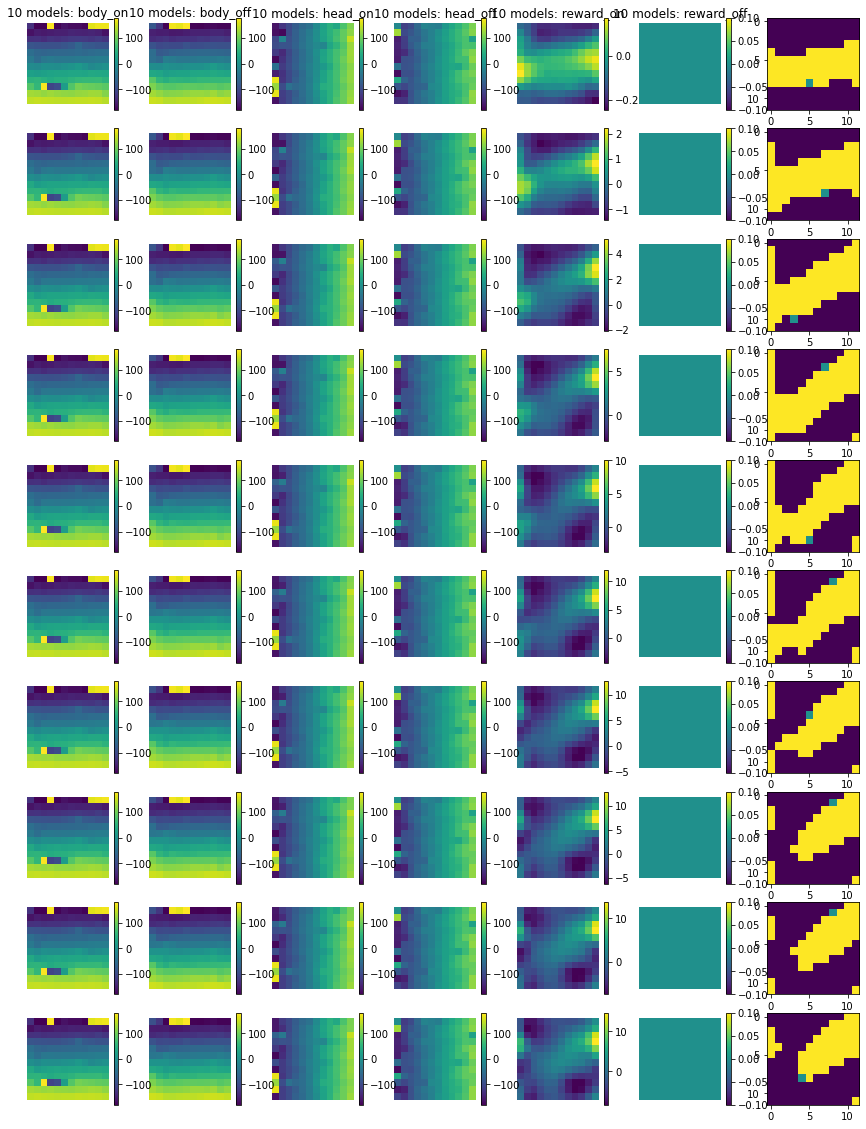

In [149]:
plot_mods(pmods)

In [155]:
msq = np.zeros(len(pmods))
for i,mod in enumerate(pmods):
    msq[i] = np.sum(np.square((mod['reward_on'][:,:,0] - mod['reward_off'][:,:,0]) / ras[i]).flatten())

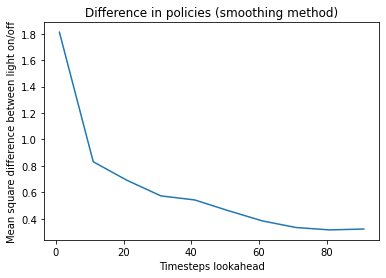

In [156]:
plt.plot(ras,msq)
plt.title('Difference in policies (smoothing method)')
plt.xlabel('Timesteps lookahead')
plt.ylabel('Mean square difference between light on/off'); # Normalized by step number